In [1]:
import numpy as np
from scipy.linalg import expm, sqrtm, inv, pinv
import matplotlib.pyplot as plt

from qutip import *

import sys

In [2]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2, EstimatorV2
from qiskit.transpiler import generate_preset_pass_manager, PassManager
from qiskit import transpile
from qiskit_aer import AerSimulator

from qiskit_experiments.library import StateTomography

In [3]:
# Constants

I = np.eye(2)

In [4]:
# "Check" helper functions

def check_trace(rho: Qobj):
    """
    Check if the trace of the density matrix is 1.
    """
    return np.isclose(rho.tr(), 1.0, atol=1e-7)

def check_hermitian(H):
    """
    Check if the operator is Hermitian.
    """
    if isinstance(H, Qobj):
        return np.allclose(H.full(), H.dag().full(), atol=1e-10)
    else:
        return np.allclose(H, H.conjugate().T, atol=1e-10)

def check_unitary(U):
    """
    Check if the operator is unitary.
    """
    return np.allclose(U @ U.conjugate().T, I, atol=1e-7) and np.allclose(U.conjugate().T @ U, I, atol=1e-6)

def check_psd(mat):
    """
    Check if the matrix is positive semi-definite.
    """
    return np.all(np.linalg.eigvals(mat) >= -1e-8)

def check_choi_decomposition(choi_matrix, pos_choi, neg_choi):
    """
    Check if the Choi matrix is decomposed correctly.
    """
    return np.allclose(choi_matrix.full(), (pos_choi - neg_choi).full(), atol=1e-8)

def check_TP(kraus_operators, tol = 1e-8):
    """
    Check if the Kraus operators are trace-preserving.
    """
    if isinstance(kraus_operators[0], Qobj):    
        M = sum([k.dag() * k for k in kraus_operators])
        isclose = np.allclose(M.full(), I, atol= tol)
    else:
        M = sum([k.conjugate().T @ k for k in kraus_operators])
        isclose = np.allclose(M, I, atol= tol)

    if not isclose:
        print(M)
        print("Deviation from TP condition: ", np.linalg.norm(M - I))

    return isclose

In [5]:
# "Compute" helper functions

def compute_fidelity(rho1: Qobj, rho2: Qobj):
    """
    Calculate the fidelity between two density matrices.
    """
    return (rho1 * rho2).tr().sqrt()

def compute_expectation_value(rho:Qobj, A):
    """
    Calculate the expectation value of an operator A with respect to a density matrix rho.
    """
    return (rho * A).tr()

In [6]:
def choi_adjointchoi_transform(choi_matrix):
    """
    Convert the Choi matrix to its adjoint form, and vice versa (As defined in the supplementary material of the paper).
    """
    if isinstance(choi_matrix, Qobj):
        U_23 = Qobj(np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]))
        adjoint_choi = choi_matrix.transform(U_23)
        # adjoint_choi = adjoint_choi.conj()
    else:
        U_23 = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])
        adjoint_choi = U_23 @ choi_matrix @ U_23
        # adjoint_choi = adjoint_choi.conjugate()
    
    return adjoint_choi

def construct_choi_matrix(map):
    """
    Construct the Choi matrix for the map.
    """

    choi_matrix = to_choi(map)

    # FIXED ERROR: The Choi matrix is not hermitian
    choi_matrix = (choi_matrix + choi_matrix.dag())/2

    return choi_matrix
    
def positive_and_negative_eigenspaces(choi_matrix):
    """
    Compute the positive and negative eigenspaces of the Choi matrix
    """
    # eigenvalues, eigenvectors = np.linalg.eigh(choi_matrix)
    eigenvalues, eigenvectors = choi_matrix.eigenstates()

    # Positive eigenspace
    pos_eigenvalues = eigenvalues[eigenvalues > 1e-9]
    pos_eigenvectors = eigenvectors[eigenvalues > 1e-9]
    
    # Negative eigenspace
    neg_eigenvalues = (-1)*eigenvalues[eigenvalues < -1e-9]
    neg_eigenvectors = eigenvectors[eigenvalues < -1e-9]
    
    return pos_eigenvalues, pos_eigenvectors, neg_eigenvalues, neg_eigenvectors


def construct_choi_matrix_from_eigenspace(eigenvalues, eigenvectors):
    """
    Construct the choi matrix of the map from the positive and negative eigenspaces
    """
    eig_list = []
    for i in range(len(eigenvalues)):
        eig_list.append(eigenvalues[i] * (eigenvectors[i] @ eigenvectors[i].dag()))

    CP_map_choi = sum(eig_list)

    CP_map_choi = (CP_map_choi + CP_map_choi.dag())/2
    
    return CP_map_choi


def decompose_into_extremal_CP_maps(choi_matrix_cp_map_adjoint):
    A = choi_matrix_cp_map_adjoint[:2, :2]
    C = choi_matrix_cp_map_adjoint[:2, 2:]
    C_dag = choi_matrix_cp_map_adjoint[2:, :2]
    B = choi_matrix_cp_map_adjoint[2:, 2:]

    assert check_psd(I - A), f"{A} - I-A not PSD"
    assert np.allclose(C.conjugate().T, C_dag, atol=1e-7), "C and C_dag are not conjugate transpose"
    assert np.allclose(B, I - A, atol=1e-7), f"B = {B}\n I - A = {I - A} \n A = {A} - B is not equal to I - A"

    sqrt_A = sqrtm(A)
    sqrt_B = sqrtm(B)

    # R = np.linalg.inv(sqrt_A) @ C @ np.linalg.inv(sqrt_B)
    R = pinv(sqrt_A) @ C @ pinv(sqrt_B)

    # print(np.linalg.norm(R)) # ---> Ensure <= 1 

    V, S, W_dag = np.linalg.svd(R)

    theta1 = np.arccos(np.clip(S[0], -1, 1))
    theta2 = np.arccos(np.clip(S[1], -1, 1))

    U1_diag = np.diag([np.exp(1j * theta1), np.exp(1j * theta2)])
    U2_diag = np.diag([np.exp(-1j * theta1), np.exp(-1j * theta2)])

    U1 = V @ U1_diag @ W_dag
    U2 = V @ U2_diag @ W_dag

    assert check_unitary(U1), "U1 is not unitary"
    assert check_unitary(U2), "U2 is not unitary"

    C1 = np.block([[A, sqrt_A @ U1 @ sqrt_B],
                   [sqrt_B @ U1.conj().T @ sqrt_A, B]])
    C2 = np.block([[A, sqrt_A @ U2 @ sqrt_B],
                   [sqrt_B @ U2.conj().T @ sqrt_A, B]])
    
    return C1, C2

def choi_to_map_in_kraus_rep(choi_matrix, skip_tp_check = False):
    """
    Convert a Choi matrix to Kraus operators.
    """
    dim = int(np.sqrt(choi_matrix.shape[0]))
    eigenvalues, eigenvectors = np.linalg.eigh(choi_matrix)
    # eigenvalues, eigenvectors = choi_matrix.eigenstates()
    kraus_operators = []

    for i in range(len(eigenvalues)):
        eigenvalue = eigenvalues[i]
        if eigenvalue > 1e-10:  # Consider only positive eigenvalues
            vector = eigenvectors[:, i]
            psi = vector.reshape((dim, dim), order='F')  # Reshape to a matrix
            K = np.sqrt(eigenvalue) * psi.T
            kraus_operators.append(np.around(K, decimals=10))
        elif eigenvalue < -1e-10:
            raise ValueError(f"Negative eigenvalue {eigenvalue} found in Choi matrix")

    if not skip_tp_check:
        assert check_TP(kraus_operators, tol=1e-7), "Kraus operators do not satisfy trace-preserving condition"

    return kraus_operators

def choi_to_map_in_kraus_rep_pos_neg(choi_matrix, skip_tp_check = False):
    """
    Convert a Choi matrix to Kraus operators.
    """
    dim = int(np.sqrt(choi_matrix.shape[0]))
    eigenvalues, eigenvectors = np.linalg.eigh(choi_matrix)
    # eigenvalues, eigenvectors = choi_matrix.eigenstates()
    kraus_operators = []

    for i in range(len(eigenvalues)):
        eigenvalue = eigenvalues[i]
        if eigenvalue > 1e-10:  # Consider only positive eigenvalues
            vector = eigenvectors[:, i]
            psi = vector.reshape((dim, dim), order='F')  # Reshape to a matrix
            K = np.sqrt(eigenvalue) * psi
            kraus_operators.append(np.around(K, decimals=10))
        elif eigenvalue < -1e-10:
            raise ValueError(f"Negative eigenvalue {eigenvalue} found in Choi matrix")

    if not skip_tp_check:
        assert check_TP(kraus_operators, tol=1e-7), "Kraus operators do not satisfy trace-preserving condition"

    return kraus_operators


def choi_to_superoperator(choi):
    """
    Convert the Choi rep to a superoperator.
    """
    kraus_operators = choi_to_map_in_kraus_rep(choi)
    dim = kraus_operators[0].shape[0]
    superoperator = np.zeros((dim**2, dim**2), dtype=complex)

    for K in kraus_operators:
        superoperator += np.kron(K.conjugate(), K)
    
    return superoperator

In [7]:
# Simulating one extremal CP map

def compute_rho_prime(kraus_operators, rho):
    """
    Compute the output density matrix from the input density matrix and the Kraus operators.
    """
    rho_prime = np.zeros_like(rho, dtype=complex)
    
    for K in kraus_operators:
        rho_prime += K @ rho @ K.conjugate().T
    
    return rho_prime

def T_matrix(kraus_operators):
    """
    Construct the T matrix from the map.
    """
    sigma_vec = [I, sigmax().full(), sigmay().full(), sigmaz().full()]
    dim = kraus_operators[0].shape[0]
    T = np.zeros((dim**2, dim**2), dtype=complex)

    for i in range(dim**2):
        for j in range(dim**2):
            T[i, j] = (1/2)*np.trace(sigma_vec[i] @ compute_rho_prime(kraus_operators, sigma_vec[j]))
    
    distortion_matrix = np.zeros((3, 3), dtype=np.float64)
    for i in range(3):
        for j in range(3):
            distortion_matrix[i, j] = np.real(T[i+1, j+1])
    
    distortion_matrix = np.real(distortion_matrix)
    
    shift_vector = T[:, 0][1:].reshape((3, 1))
    
    return T, distortion_matrix, shift_vector

def compute_unitary_and_angles(distortion_matrix, shift_vector):

    R1, T_prime, R2_T = np.linalg.svd(distortion_matrix, full_matrices=False)

    det_R1 = np.linalg.det(R1)
    det_R2 = np.linalg.det(R2_T)

    R1 = R1 / det_R1
    R2_T = R2_T / det_R2
    T_prime = T_prime / (det_R1 * det_R2)

    T_prime = np.real(np.diag(T_prime))

    nu = np.arccos(np.clip(T_prime[0, 0], -1, 1))
    mu = np.arccos(np.clip(T_prime[1, 1], -1, 1))

    assert np.isclose(T_prime[2, 2], np.cos(nu)*np.cos(mu), atol=1e-10), "T_prime[2] is not equal to cos(nu)*cos(mu)"

    t_prime = R2_T @ shift_vector

    # nu and mu could be positive or negative
    if t_prime[2, 0] < 0:
        mu = -mu

    assert np.isclose(t_prime[0, 0], 0, atol=1e-4), "t_prime[0] is not equal to 0"
    assert np.isclose(t_prime[1, 0], 0, atol=1e-4), "t_prime[1] is not equal to 0"
    assert np.isclose(t_prime[2, 0], np.sin(mu)*np.sin(nu), atol=1e-7), "t_prime[2, 0] is not equal to sin(mu)*sin(nu)"

    return R1, R2_T.T, mu, nu


def so3_to_su2(R):
    sigma_vec = [sigmax().full(), sigmay().full(), sigmaz().full()]

    theta = np.arccos(np.clip((1/2)*(np.trace(R) - 1), -1, 1))

    if np.isclose(theta, 0, atol=1e-10):
        return np.eye(2), None, None

    eigvals, eigvecs = np.linalg.eig(R)
    idx = np.argmin(np.abs(eigvals - 1))

    n = np.real(eigvecs[:, idx])
    n = n / np.linalg.norm(n)

    sigma_n = np.sum([n[i] * sigma_vec[i] for i in range(3)], axis=0)

    U = expm(-1j * theta/2 * sigma_n)

    assert check_unitary(U), "U is not unitary"

    return U, n, theta

In [8]:
def work_out_forward(U1, V1, mu1, nu1):
    obs = sigmaz()*(-1/2) + qeye(2)*(1/2)

    psi_01 = tensor(basis(2, 1), basis(2, 0))
    rho_01 = psi_01 * psi_01.dag()

    alpha_1 = (1/2)*(mu1 + nu1)
    beta_1 = (1/2)*(mu1 - nu1)

    gamma_11 = (1/2)*(beta_1 - alpha_1 + np.pi/2)
    gamma_12 = (1/2)*(beta_1 + alpha_1 - np.pi/2)

    U1 = Qobj(U1)
    V1 = Qobj(V1)

    V1 = tensor(V1, qeye(2))

    rho_01 = V1 * rho_01 * V1.dag()

    ry_ancilla_1 = tensor(qeye(2), gates.ry(2*gamma_11))
    rho_01 = ry_ancilla_1 * rho_01 * ry_ancilla_1.dag()

    # Apply CNOT (control: data, target: ancilla)
    cnot_gate = gates.cnot()
    rho_01 = cnot_gate * rho_01 * cnot_gate.dag()

    # Apply Ry(2*gamma_12) and Ry(2*gamma_22) to ancilla (second qubit)
    ry_ancilla_1b = tensor(qeye(2), gates.ry(2*gamma_12))

    rho_01 = ry_ancilla_1b * rho_01 * ry_ancilla_1b.dag()

    # Measurement and conditional X on data qubit (simulate measurement on ancilla)
    # Projector for ancilla = |1>
    P0 = tensor(qeye(2), basis(2,0)*basis(2,0).dag())
    P1 = tensor(qeye(2), basis(2,1)*basis(2,1).dag())
    prob_01_0 = (P0 * rho_01).tr().real
    prob_01_1 = (P1 * rho_01).tr().real

    U1 = tensor(U1, qeye(2))

    rho_01_1 = (P1 * rho_01 * P1.dag()) / prob_01_1
    rho_01_0 = (P0 * rho_01 * P0.dag()) / prob_01_0

    X_data = tensor(sigmax(), qeye(2))
    rho_01_1 = X_data * rho_01_1 * X_data.dag()
    rho_01_1 = U1 * rho_01_1 * U1.dag()

    rho_01_0 = U1 * rho_01_0 * U1.dag()

    rho_01 = prob_01_1 * rho_01_1 + prob_01_0 * rho_01_0

    rho_01 = rho_01.ptrace(0)

    exp_val = expect(obs, rho_01)

    return exp_val, rho_01

In [9]:
# Build circuit

def build_circuit(U, V, mu, nu, time_step, initial_state = "0", last = True):
    """
    Build the circuit from the unitary and angles
    """
    alpha = (1/2)*(mu + nu)
    beta = (1/2)*(mu - nu)

    gamma_1 = (1/2)*(beta - alpha + np.pi/2)
    gamma_2 = (1/2)*(beta + alpha - np.pi/2)

    qubits = QuantumRegister(2, "q")
    cbits = ClassicalRegister(2, "c")
    circuit = QuantumCircuit(qubits, cbits)

    (data, ancilla) = qubits
    (c0, c1) = cbits

    # initial state
    if initial_state == "1":
        circuit.x(data)
    elif initial_state == "+":
        circuit.h(data)
    elif initial_state == "-":
        circuit.x(data)
        circuit.h(data)

    # for step in range(time_step):
    circuit.unitary(V, [data], label="V")
    circuit.ry(2*gamma_1, ancilla)
    circuit.cx(data, ancilla)
    circuit.ry(2*gamma_2, ancilla)

    circuit.measure(ancilla, c1)
    
    with circuit.if_test((c1, 1)):
        circuit.x(data)
        if not last:
            circuit.x(ancilla)
    
    circuit.unitary(U, [data], label="U")
    
    if last:
        circuit.measure(data, c0)
    
    return circuit

# Running the Circuit with Simulator/IBM device

def run_circuit(observable, circuit, sim = 'Yes', backend_name = None):
    if sim == 'Yes':
        sim_backend = AerSimulator()
        pm = generate_preset_pass_manager(backend=sim_backend, optimization_level=3)
        qc = pm.run(circuit)
        estimator = EstimatorV2(sim_backend)
        estimator.options.default_shots = 10000
        job = estimator.run([(qc, observable )])
        result = job.result()
    elif sim == 'No':
        service = QiskitRuntimeService()
        backend = service.backend(backend_name)
        transpiled_circuit = transpile(circuit, backend=backend, optimization_level=3)

        with Session(backend=backend) as session:
            estimator = EstimatorV2(session=session)
            estimator.options.default_shots = 10000
            job = estimator.run([(transpiled_circuit, observable)])
            result = job.result()

    return result[0].data.evs

In [10]:
def single_forward_step_run(dynamical_map):
    '''
    Returns the circuits for the single forward step of the dynamical map
    '''
    
    choi_matrix = construct_choi_matrix(dynamical_map)
    pos_eigenvalues, pos_eigenvectors, neg_eigenvalues, neg_eigenvectors = positive_and_negative_eigenspaces(choi_matrix)
    
    CP_map_choi_pos = construct_choi_matrix_from_eigenspace(pos_eigenvalues, pos_eigenvectors)

    assert check_choi_decomposition(choi_matrix, CP_map_choi_pos, 0), "Choi decomposition is not correct"

    choi_matrix_cp_map_adjoint = choi_adjointchoi_transform(CP_map_choi_pos)
    C1, C2 = decompose_into_extremal_CP_maps(choi_matrix_cp_map_adjoint)
    kraus_operators_C1 = choi_to_map_in_kraus_rep(C1)
    kraus_operators_C2 = choi_to_map_in_kraus_rep(C2)

    T_C1, distortion_matrix_C1, shift_vector_C1 = T_matrix(kraus_operators_C1)
    T_C2, distortion_matrix_C2, shift_vector_C2 = T_matrix(kraus_operators_C2)

    R11, R12, mu1, nu1 = compute_unitary_and_angles(distortion_matrix_C1, shift_vector_C1)
    R21, R22, mu2, nu2 = compute_unitary_and_angles(distortion_matrix_C2, shift_vector_C2)

    U1, n1, theta1 = so3_to_su2(R11)
    U2, n2, theta2 = so3_to_su2(R21)
    V1, n1, theta1 = so3_to_su2(R12)
    V2, n2, theta2 = so3_to_su2(R22)

    return U1, U2, V1, V2, mu1, mu2, nu1, nu2

def build_single_forward_step_circuit(U1, U2, V1, V2, mu1, mu2, nu1, nu2, time_step, initial_state = "0", last = True):
    circuit_1 = build_circuit(U1, V1, mu1, nu1, time_step, initial_state = initial_state, last = last)
    circuit_2 = build_circuit(U2, V2, mu2, nu2, time_step, initial_state = initial_state, last = last)

    return circuit_1, circuit_2

In [11]:
# Lindbladian to General Dynamical Map

def get_liouvillian_superoperator(omega, gamma, beta):

    # Pauli operators
    sz = sigmaz()
    sm = sigmam()
    sp = sigmap()

    H = 0.5 * omega * sz

    # Jump operators
    L1 = np.sqrt(gamma * np.exp(beta * omega)) * sm  # excitation
    L2 = np.sqrt(gamma) * sp                         # relaxation

    L = liouvillian(H, [L1, L2])
    return L


def get_dynamical_map(L, dt, coefficient = 1):
    """
    Get the dynamical map from the Liouvillian superoperator for time dt.
    """
    # Time evolution operator
    U = (coefficient * L * dt).expm()
    
    return U

In [12]:
omega, gamma, beta = 1.0, 1.0, 1.0

L = get_liouvillian_superoperator(omega, gamma, beta)
dt = 0.05
total_time = 0.5
time_steps = int(total_time/dt)
print(time_steps)

10


In [13]:
observable = SparsePauliOp.from_sparse_list([("Z", [0], -1/2), ("I", [0], 1/2)], num_qubits=2)

results = []

# U1, U2, V1, V2, mu1, mu2, nu1, nu2 = single_forward_step_run(dynamical_map)

for step in range(time_steps):
    dynamical_map = get_dynamical_map(L, dt*(step + 1))

    U1, U2, V1, V2, mu1, mu2, nu1, nu2 = single_forward_step_run(dynamical_map)

    result_1, rho_last_1 = work_out_forward(U1, V1, mu1, nu1)
    result_2, rho_last_2 = work_out_forward(U2, V2, mu2, nu2)

    # circuit_1, circuit_2 = build_single_forward_step_circuit(U1, U2, V1, V2, mu1, mu2, nu1, nu2, step, initial_state = "+")
    # result_1 = run_circuit(observable, circuit_1)
    # result_2 = run_circuit(observable, circuit_2)

    result = (result_1 + result_2)/2
    results.append(result)
    print(f"Step {step} result: {result}")

Step 0 result: 0.9543727231978049
Step 1 result: 0.9164863453890333
Step 2 result: 0.8850275837883009
Step 3 result: 0.8589059607902929
Step 4 result: 0.8372160036572115
Step 5 result: 0.8192058578703385
Step 6 result: 0.8042512245915374
Step 7 result: 0.7918337208661059
Step 8 result: 0.781522909564173
Step 9 result: 0.7729613797225823


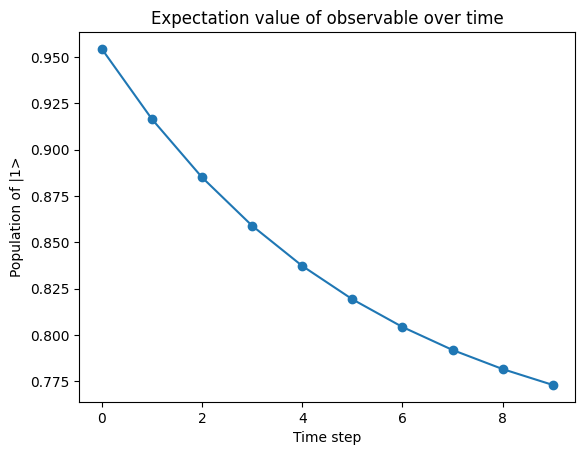

In [14]:
import matplotlib.pyplot as plt

plt.plot(results, "-o", label="Initial state = |1>")
# plt.ylim(0.47, 0.55)
plt.xlabel("Time step")
plt.ylabel("Population of |1>")
plt.title("Expectation value of observable over time")
plt.show()

In [15]:
# np.save("./pop1_initial+.npy", np.array(results))

In [16]:
rho_last = (1/2)*rho_last_1 + (1/2)*rho_last_2
rho_last

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[2.27038620e-01+6.30158759e-18j 2.63841009e-09+2.56435776e-09j]
 [2.63841009e-09-2.56435776e-09j 7.72961380e-01-2.14539880e-17j]]

# Reverse evolution

In [17]:
def calculate_p(kraus_operators_M):
    lower_bound = sum([m.conjugate().T @ m for m in kraus_operators_M])
    lower_bound_max = np.max(np.real(lower_bound))
    p = int(lower_bound_max) + 1
    return p

def construct_D(kraus_operators_M, p):
    M_dag_M_sum = np.around(sum([m.conjugate().T @ m for m in kraus_operators_M]), 8)

    D2 = p*I - M_dag_M_sum
    assert check_psd(D2), "D2 is not psd"
    assert check_hermitian(D2), "D2 is not hermitian"

    D = sqrtm(D2)
    assert check_psd(D), "D is not PSD"
    return D

def kraus_op_to_choi(kraus_operators):
    d = kraus_operators[0].shape[0]

    phi = sum(np.kron(np.eye(1, d, i).T, np.eye(1, d, i).T) for i in range(d))
    phi = phi.reshape((d*d, 1))
    proj = phi @ phi.conjugate().T

    choi = np.zeros((d*d, d*d), dtype=complex)
    I = np.eye(d)
    for K in kraus_operators:
        K_tensor_I = np.kron(K, I)
        choi += K_tensor_I @ proj @ K_tensor_I.conj().T
    
    assert check_hermitian(choi), "Choi matrix not hermitian"
    assert check_psd(choi), f"{np.linalg.eigvalsh(choi)} - Choi matrix not PSD"
    
    return choi

In [18]:
def work_out_reverse(U1, V1, mu1, nu1, rho_last):
    obs = sigmaz()*(-1/2) + qeye(2)*(1/2)

    rho_second = basis(2, 0)*basis(2, 0).dag()
    rho_01 = tensor(rho_last, rho_second)

    alpha_1 = (1/2)*(mu1 + nu1)
    beta_1 = (1/2)*(mu1 - nu1)

    gamma_11 = (1/2)*(beta_1 - alpha_1 + np.pi/2)
    gamma_12 = (1/2)*(beta_1 + alpha_1 - np.pi/2)

    U1 = Qobj(U1)
    V1 = Qobj(V1)

    V1 = tensor(V1, qeye(2))

    rho_01 = V1 * rho_01 * V1.dag()

    ry_ancilla_1 = tensor(qeye(2), gates.ry(2*gamma_11))
    rho_01 = ry_ancilla_1 * rho_01 * ry_ancilla_1.dag()

    # Apply CNOT (control: data, target: ancilla)
    cnot_gate = gates.cnot()
    rho_01 = cnot_gate * rho_01 * cnot_gate.dag()

    # Apply Ry(2*gamma_12) and Ry(2*gamma_22) to ancilla (second qubit)
    ry_ancilla_1b = tensor(qeye(2), gates.ry(2*gamma_12))

    rho_01 = ry_ancilla_1b * rho_01 * ry_ancilla_1b.dag()

    # Measurement and conditional X on data qubit (simulate measurement on ancilla)
    # Projector for ancilla = |1>
    P0 = tensor(qeye(2), basis(2,0)*basis(2,0).dag())
    P1 = tensor(qeye(2), basis(2,1)*basis(2,1).dag())
    prob_01_0 = (P0 * rho_01).tr().real
    prob_01_1 = (P1 * rho_01).tr().real

    U1 = tensor(U1, qeye(2))

    rho_01_1 = (P1 * rho_01 * P1.dag()) / prob_01_1
    rho_01_0 = (P0 * rho_01 * P0.dag()) / prob_01_0

    X_data = tensor(sigmax(), qeye(2))
    rho_01_1 = X_data * rho_01_1 * X_data.dag()
    rho_01_1 = U1 * rho_01_1 * U1.dag()

    rho_01_0 = U1 * rho_01_0 * U1.dag()

    rho_01 = prob_01_1 * rho_01_1 + prob_01_0 * rho_01_0

    rho_01 = rho_01.ptrace(0)

    exp_val = expect(obs, rho_01)

    return exp_val, rho_01

In [19]:
# Build circuit

def build_circuit_reverse(U, V, mu, nu, circuit_last):
    """
    Build the circuit from the unitary and angles
    """
    alpha = (1/2)*(mu + nu)
    beta = (1/2)*(mu - nu)

    gamma_1 = (1/2)*(beta - alpha + np.pi/2)
    gamma_2 = (1/2)*(beta + alpha - np.pi/2)

    qubits = QuantumRegister(2, "q")
    cbits = ClassicalRegister(2, "c")
    circuit = QuantumCircuit(qubits, cbits)

    (data, ancilla) = qubits
    (c0, c1) = cbits

    # initial state
    # if initial_state == "1":
    #     circuit.x(data)
    # elif initial_state == "+":
    #     circuit.h(data)
    # elif initial_state == "-":
    #     circuit.x(data)
    #     circuit.h(data)

    circuit.unitary(V, [data], label="V")
    circuit.ry(2*gamma_1, ancilla)
    circuit.cx(data, ancilla)
    circuit.ry(2*gamma_2, ancilla)

    circuit.measure(ancilla, c1)
    
    with circuit.if_test((c1, 1)):
        circuit.x(data)
        # circuit.x(ancilla)
    
    circuit.unitary(U, [data], label="U")

    circuit.measure(data, c0)

    circuit_update = circuit_last.compose(circuit)

    return circuit_update

# Running the Circuit with Simulator/IBM device

def run_circuit_rev(observable, circuit, sim = 'Yes'):
    if sim == 'Yes':
        sim_backend = AerSimulator(method='density_matrix')
        pm = generate_preset_pass_manager(backend=sim_backend, optimization_level=3)
        qc = pm.run(circuit)
        estimator = EstimatorV2(sim_backend)
        estimator.options.default_shots = 10000
        job = estimator.run([(qc, observable )])
        result = job.result()
    elif sim == 'No':
        pass

    return result[0].data.evs

In [20]:
def single_reverse_step_run(dynamical_map, p):
    '''
    Returns the circuits for the single forward step of the dynamical map
    '''
    choi_matrix = construct_choi_matrix(dynamical_map)

    pos_eigenvalues, pos_eigenvectors, neg_eigenvalues, neg_eigenvectors = positive_and_negative_eigenspaces(choi_matrix)

    CP_map_choi_pos = construct_choi_matrix_from_eigenspace(pos_eigenvalues, pos_eigenvectors)
    CP_map_choi_neg = construct_choi_matrix_from_eigenspace(neg_eigenvalues, neg_eigenvectors)

    assert check_choi_decomposition(choi_matrix, CP_map_choi_pos, CP_map_choi_neg), "Choi decomposition is not correct"

    pos_eigenspace_kraus_op = choi_to_map_in_kraus_rep_pos_neg(CP_map_choi_pos.full(), skip_tp_check=True)
    neg_eigenspace_kraus_op = choi_to_map_in_kraus_rep_pos_neg(CP_map_choi_neg.full(), skip_tp_check=True)

    # p = calculate_p(neg_eigenspace_kraus_op)
    D = construct_D(neg_eigenspace_kraus_op, p)

    TP_pos_eigenspace_kraus_op = [(1/np.sqrt(1 + p))*k for k in pos_eigenspace_kraus_op]
    TP_pos_eigenspace_kraus_op.append((1/np.sqrt(1 + p))*D)

    TP_neg_eigenspace_kraus_op = [(1/np.sqrt(p))*m for m in neg_eigenspace_kraus_op]
    TP_neg_eigenspace_kraus_op.append((1/np.sqrt(p))*D)

    assert check_TP(TP_pos_eigenspace_kraus_op, tol = 1e-7), "TP pos eigenspace not satisfied"
    assert check_TP(TP_neg_eigenspace_kraus_op, tol = 1e-7), "TP neg eigensapce not satisfied"

    # Positive branch
    pos_choi_matrix_cptp_map = kraus_op_to_choi(TP_pos_eigenspace_kraus_op)
    # pos_choi_matrix_cptp_map_adjoint = choi_adjointchoi_transform(pos_choi_matrix_cptp_map)
    C1, C2 = decompose_into_extremal_CP_maps(pos_choi_matrix_cptp_map)
    kraus_operators_C1 = choi_to_map_in_kraus_rep(C1)
    kraus_operators_C2 = choi_to_map_in_kraus_rep(C2)

    T_C1, distortion_matrix_C1, shift_vector_C1 = T_matrix(kraus_operators_C1)
    T_C2, distortion_matrix_C2, shift_vector_C2 = T_matrix(kraus_operators_C2)

    R11, R12, mu1, nu1 = compute_unitary_and_angles(distortion_matrix_C1, shift_vector_C1)
    R21, R22, mu2, nu2 = compute_unitary_and_angles(distortion_matrix_C2, shift_vector_C2)

    U1, n1, theta1 = so3_to_su2(R11)
    U2, n2, theta2 = so3_to_su2(R21)
    V1, n1, theta1 = so3_to_su2(R12)
    V2, n2, theta2 = so3_to_su2(R22)

    # Negative branch
    neg_choi_matrix_cptp_map = kraus_op_to_choi(TP_neg_eigenspace_kraus_op)
    # neg_choi_matrix_cptp_map_adjoint = choi_adjointchoi_transform(neg_choi_matrix_cptp_map)
    C3, C4 = decompose_into_extremal_CP_maps(neg_choi_matrix_cptp_map)
    kraus_operators_C3 = choi_to_map_in_kraus_rep(C3)
    kraus_operators_C4 = choi_to_map_in_kraus_rep(C4)

    T_C3, distortion_matrix_C3, shift_vector_C3 = T_matrix(kraus_operators_C3)
    T_C4, distortion_matrix_C4, shift_vector_C4 = T_matrix(kraus_operators_C4)

    R11_, R12_, mu3, nu3 = compute_unitary_and_angles(distortion_matrix_C3, shift_vector_C3)
    R21_, R22_, mu4, nu4 = compute_unitary_and_angles(distortion_matrix_C4, shift_vector_C4)

    U3, n1, theta1 = so3_to_su2(R11_)
    U4, n2, theta2 = so3_to_su2(R21_)
    V3, n1, theta1 = so3_to_su2(R12_)
    V4, n2, theta2 = so3_to_su2(R22_)

    return U1, U2, V1, V2, mu1, mu2, nu1, nu2, U3, U4, V3, V4, mu3, mu4, nu3, nu4

def build_single_reverse_step_circuit_pos_branch(U1, U2, V1, V2, mu1, mu2, nu1, nu2, circuit_last):
    circuit_1 = build_circuit_reverse(U1, V1, mu1, nu1, circuit_last)
    circuit_2 = build_circuit_reverse(U2, V2, mu2, nu2, circuit_last)

    return circuit_1, circuit_2

def build_single_reverse_step_circuit_neg_branch(U3, U4, V3, V4, mu3, mu4, nu3, nu4, circuit_last):
    circuit_3 = build_circuit_reverse(U3, V3, mu3, nu3, circuit_last)
    circuit_4 = build_circuit_reverse(U4, V4, mu4, nu4, circuit_last)

    return circuit_3, circuit_4

In [21]:
from qiskit_aer.library import save_density_matrix
from qiskit.quantum_info import DensityMatrix, partial_trace

# initial_state = DensityMatrix([[0.14109404, 0],[0, 0.85890596]])
# initial_state

In [22]:
dynamical_map_last = get_dynamical_map(L, dt*20)

U1, U2, V1, V2, mu1, mu2, nu1, nu2 = single_forward_step_run(dynamical_map_last)

circuit_last_1, circuit_last_2 = build_single_forward_step_circuit(U1, U2, V1, V2, mu1, mu2, nu1, nu2, None, initial_state = "1", last = False)

In [23]:
rho_last

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[2.27038620e-01+6.30158759e-18j 2.63841009e-09+2.56435776e-09j]
 [2.63841009e-09-2.56435776e-09j 7.72961380e-01-2.14539880e-17j]]

In [24]:
observable = SparsePauliOp.from_sparse_list([("Z", [0], -1/2), ("I", [0], 1/2)], num_qubits=2)
p = 1000
results = []

for step in range(time_steps - 1):
    dynamical_map = get_dynamical_map(L, dt*(step + 1), coefficient=-1)

    U1, U2, V1, V2, mu1, mu2, nu1, nu2, U3, U4, V3, V4, mu3, mu4, nu3, nu4 = single_reverse_step_run(dynamical_map, p)

    result_11, rho_last_11 = work_out_reverse(U1, V1, mu1, nu1, rho_last)
    result_21, rho_last_21 = work_out_reverse(U2, V2, mu2, nu2, rho_last)

    # circuit_11, circuit_21 = build_single_reverse_step_circuit_pos_branch(U1, U2, V1, V2, mu1, mu2, nu1, nu2, circuit_last_1)
    # result_11 = run_circuit_rev(observable, circuit_11)
    # result_21 = run_circuit_rev(observable, circuit_21)

    result_plus = (result_11 + result_21)/2

    # circuit_21, circuit_22 = build_single_reverse_step_circuit_pos_branch(U1, U2, V1, V2, mu1, mu2, nu1, nu2, circuit_last_2)
    # result_21 = run_circuit_rev(observable, circuit_21)
    # result_22 = run_circuit_rev(observable, circuit_22)

    # circuit_31, circuit_41 = build_single_reverse_step_circuit_neg_branch(U3, U4, V3, V4, mu3, mu4, nu3, nu4, circuit_last_1)
    # result_31 = run_circuit_rev(observable, circuit_31)
    # result_41 = run_circuit_rev(observable, circuit_41)

    result_31, rho_last_31 = work_out_reverse(U3, V3, mu3, nu3, rho_last)
    result_41, rho_last_41 = work_out_reverse(U4, V4, mu4, nu4, rho_last)

    result_minus = (result_31 + result_41)/2

    # circuit_32, circuit_42 = build_single_reverse_step_circuit_neg_branch(U3, U4, V3, V4, mu3, mu4, nu3, nu4, circuit_last_2)
    # result_32 = run_circuit_rev(observable, circuit_32)
    # result_42 = run_circuit_rev(observable, circuit_42)

    print(result_plus)
    print(result_minus)
    
    result = (1+p)*result_plus - p*result_minus
    # result = result/(1+2*p)

    results.append(result)
    print(f"Step {step} result: {result}")

0.7729613797156367
0.7729528182503594
Step 0 result: 0.7815228449928782
0.7729613797121753
0.7729425074363271
Step 1 result: 0.7918336555603673
0.7729613796896057
0.7729300898577689
Step 2 result: 0.8042512115264344
0.772944238985015
0.7729151351856887
Step 3 result: 0.8020480383113409
0.7729613797156064
0.7728971250933336
Step 4 result: 0.837216001988395
0.7729145944760569
0.7728754351514501
Step 5 result: 0.8120739190828772
0.7729613797159273
0.7728493134581478
Step 6 result: 0.8850276374954547
0.7729613797225824
0.7728178547701154
Step 7 result: 0.9164863321894927
0.7729613797209987
0.772779968454807
Step 8 result: 0.9543726459127129


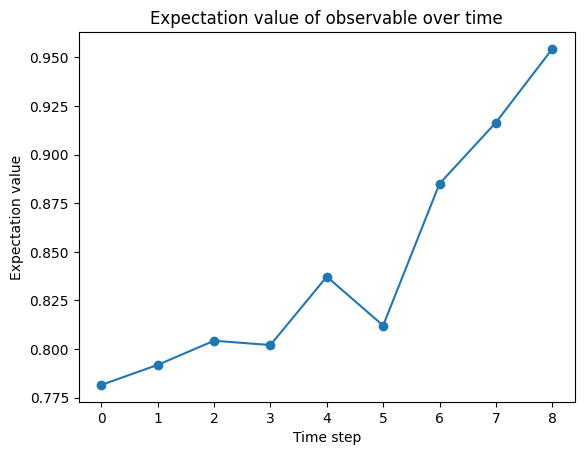

In [25]:
import matplotlib.pyplot as plt

plt.plot(results, "-o")
# plt.ylim(0.47, 0.55)
plt.xlabel("Time step")
plt.ylabel("Expectation value")
plt.title("Expectation value of observable over time")
plt.show()

In [26]:
rho_last

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[2.27038620e-01+6.30158759e-18j 2.63841009e-09+2.56435776e-09j]
 [2.63841009e-09-2.56435776e-09j 7.72961380e-01-2.14539880e-17j]]